# Customer Churn Prediction and Analysis


This project aims to predict which customers are more likely to discontinue their subscription service, also known as churn prediction. Using the Telco Customer Churn dataset from Kaggle, I will apply data analysis techniques to classify customers as “returned” or “churned”. The dataset includes information regarding the customers’ demographics, the services they subscribed to, whether the customer left within the last month, and account information. The goal is to compare simple machine learning models with a deep learning approach to see which provides better predictions and business insights.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras import layers, models

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float64
 16  unan_dat_Mean     10

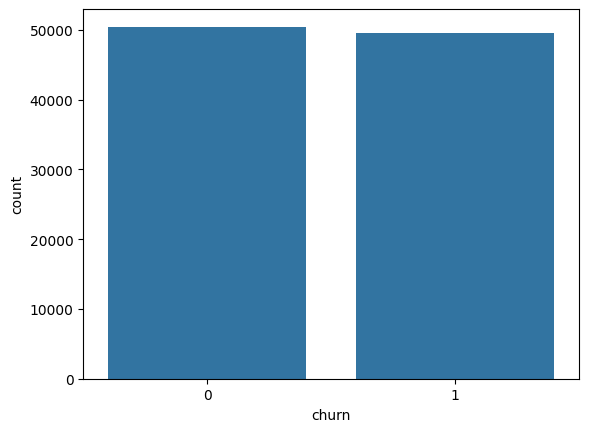

In [5]:
# 1. Loading the Dataset
df = pd.read_csv('Telco-Customer-Churn.csv')
df.head()
df.info()
sns.countplot(x='churn', data=df)
plt.show()

In [21]:
# 2. Data preprocessing
df["churn"] = LabelEncoder().fit_transform(df["churn"])
df = pd.get_dummies(df, drop_first=True)

# Handle missing values
from sklearn.impute import SimpleImputer

# Create an imputer that replaces NaN with the column mean (for numeric)
imputer = SimpleImputer(strategy='mean')

# Apply it only to numeric columns
X = df.drop("churn", axis=1)
y = df["churn"]

X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X = df.drop("churn", axis=1)
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# 3. Baseline models
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

# 3.1. Model evaluation
for name, preds in [('Logistic Regression', lr_preds), ('Random Forest', rf_preds)]:
    print(f"{name}")
    print(f"Accuracy: {accuracy_score(y_test, preds):.3f}")
    print(f"F1 Score: {f1_score(y_test, preds):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, preds):.3f}\n")


Logistic Regression
Accuracy: 0.602
F1 Score: 0.584
ROC AUC: 0.602

Random Forest
Accuracy: 0.615
F1 Score: 0.601
ROC AUC: 0.614



In [ ]:
# 4. Deep Neural Network model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

loss, accuracy, auc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.3f}, Test AUC: {auc:.3f}")

In [ ]:
# 5. Model visualization
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('DNN Accuracy Over Epochs')
plt.show()

In [ ]:
# 6. Save the models

import joblib

# Save models
joblib.dump(lr, "models/logistic_regression.pkl")
joblib.dump(rf, "models/random_forest.pkl")
model.save("models/dnn_model.h5")
